# Convolutional Neural Network (CNN)

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [87]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [88]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


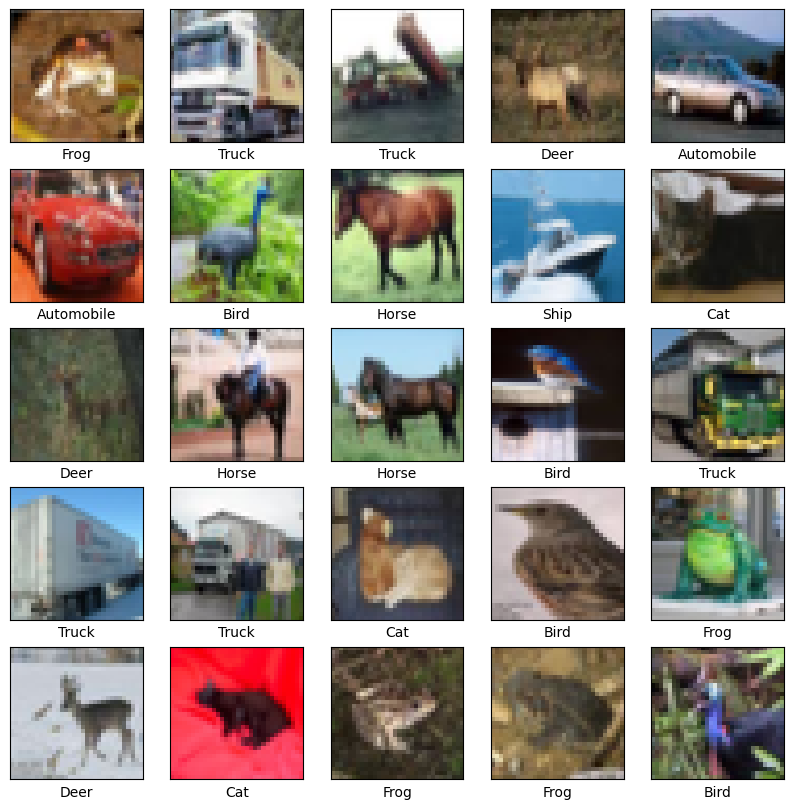

In [89]:
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [90]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

c:\Users\dearh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the architecture of your model so far:

In [91]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [92]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [93]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [94]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics= ['accuracy'])

In [95]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True, # the model keeps the best epoch weights, not the last ones
)

In [96]:
history = model.fit(train_images, train_labels, epochs=5, batch_size=1024, validation_split=0.33, callbacks=early_stopping)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.2451 - loss: 2.0550 - val_accuracy: 0.3208 - val_loss: 1.8603
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.3687 - loss: 1.7548 - val_accuracy: 0.3974 - val_loss: 1.6513
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.4280 - loss: 1.5906 - val_accuracy: 0.4387 - val_loss: 1.5366
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.4687 - loss: 1.4730 - val_accuracy: 0.4509 - val_loss: 1.5082
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.4949 - loss: 1.4080 - val_accuracy: 0.4966 - val_loss: 1.4134


### Evaluate the model

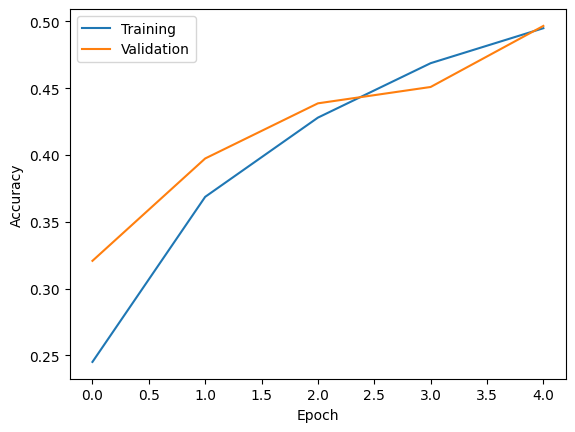

313/313 - 1s - 2ms/step - accuracy: 0.4986 - loss: 1.4041


In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(["Training","Validation"])
plt.show()
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

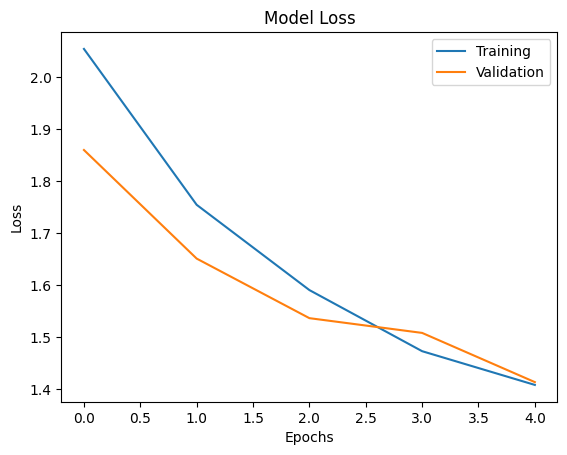

In [98]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(["Training","Validation"])
plt.show()

In [99]:
pred_labels=model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [100]:
pred_labels

array([[-2.0205057 , -2.634682  ,  1.2902803 , ..., -0.37681717,
        -1.2138102 , -1.2718301 ],
       [ 3.2661397 ,  3.6850095 , -1.4513577 , ..., -4.558955  ,
         5.042994  ,  2.39595   ],
       [ 1.5658145 ,  1.7504245 , -0.27229834, ..., -2.121189  ,
         2.8237782 ,  1.1075726 ],
       ...,
       [-2.5060992 , -4.562189  ,  2.1475613 , ...,  3.073147  ,
        -3.5033598 , -1.7775615 ],
       [-1.1162422 ,  0.84696513, -0.5688366 , ...,  0.03305375,
        -1.6806644 ,  0.05962466],
       [-2.4122071 , -2.7673304 ,  0.30878106, ...,  3.688399  ,
        -2.8052053 , -1.6181668 ]], dtype=float32)

In [101]:
pred_labels = np.argmax(pred_labels, axis=1)

In [102]:
pred_labels[0:5]

array([3, 8, 8, 8, 6], dtype=int64)

In [103]:
test_labels[0:5]

array([[3],
       [8],
       [8],
       [0],
       [6]], dtype=uint8)

In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix(pred_labels,test_labels)

array([[410,  25,  49,   8,  27,   6,   2,  10,  93,  27],
       [ 24, 529,   6,   6,   3,   1,   5,   2,  61,  86],
       [120,  16, 387, 110, 176, 122,  79,  45,  68,  22],
       [ 47,  35, 192, 472, 134, 278, 121, 130,  40,  42],
       [ 23,   4,  89,  32, 304,  30,  68,  37,   3,   3],
       [  5,   6,  67, 133,  44, 385,  13,  69,   7,  11],
       [ 24,  21,  90,  88, 133,  29, 636,  20,  12,  39],
       [ 29,  41,  77, 114, 151, 122,  39, 640,  15,  65],
       [253, 101,  25,  11,  14,  10,   9,   8, 614,  96],
       [ 65, 222,  18,  26,  14,  17,  28,  39,  87, 609]], dtype=int64)

In [105]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_labels,test_labels)

0.4986

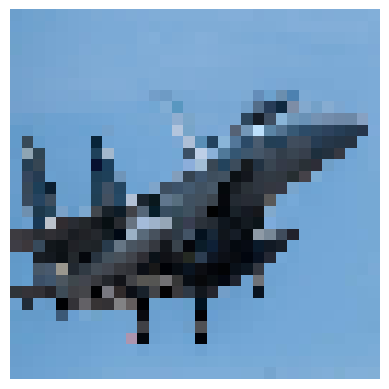

In [106]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess image
img_path = "C:\\Users\\dearh\\Downloads\\Vision_AI-main\\A6.jpg"  # replace with your image path
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# To display the image, remove the batch dimension
plt.imshow(img_array[0])
plt.axis('off')  # hide axes
plt.show()


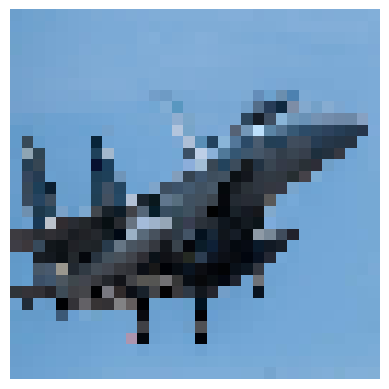

In [107]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [108]:
prediction = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [109]:
prediction

array([[ 1.7925677 ,  1.8491629 , -0.72470045, -2.4640558 , -1.624378  ,
        -4.3273444 , -2.6468787 , -2.097537  ,  1.4672302 ,  2.1616104 ]],
      dtype=float32)

In [110]:
predicted_index = np.argmax(prediction, axis=1)[0]
print("Predicted class:", class_names[predicted_index])

Predicted class: Truck


In [111]:
# After training is complete, save the model
model.save('cifar10_model.h5')
print("Model saved successfully!")

Model saved successfully!
